In [1]:
from google.colab import files
uploaded = files.upload()


Saving creditcard.csv.zip to creditcard.csv.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile('creditcard.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()



In [3]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("Shape of dataset:", df.shape)
print("\nClass distribution:\n", df['Class'].value_counts())
print("\nPercentage frauds:", round(df['Class'].value_counts()[1] / len(df) * 100, 2), '%')



Shape of dataset: (284807, 31)

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Percentage frauds: 0.17 %


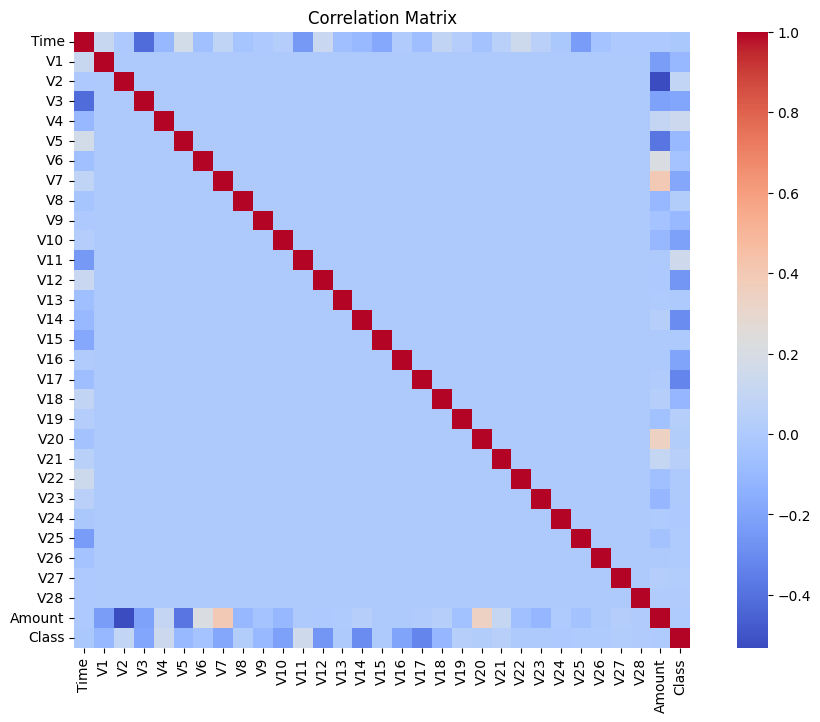

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmax=1.0, square=True)
plt.title("Correlation Matrix")
plt.show()


This heatmap visualizes the correlation between features. It helps identify strongly related features which may help or hurt the model (feature selection step).

We separate the features (X) from the target labels (y). This is necessary before training a machine learning model.

In [6]:
X = df.drop("Class", axis=1)  # Features
y = df["Class"]               # Labels (0: normal, 1: fraud)



The data is split into 80% training and 20% testing while maintaining the class distribution using stratify=y.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


SMOTE (Synthetic Minority Over-sampling Technique) is used to balance the training data by generating synthetic samples for the minority class (fraudulent transactions).



In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())



Class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


Scaling the data.

In [10]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


Train the Logistic Regression model with scaled data and use liblinear solver to avoid convergence warnings.

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_scaled, y_train_resampled)


LogisticRegression(max_iter=1000, solver='liblinear')

Make Predictions and Evaluate
Make predictions and print performance metrics including confusion matrix, precision, recall, F1-score, and accuracy.



In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[56298   566]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Accuracy Score: 0.9898879955057758


ROC Curve and AUC
Plot the ROC curve to visualize the performance of the classifier. AUC shows how well the model separates fraud and non-fraud.



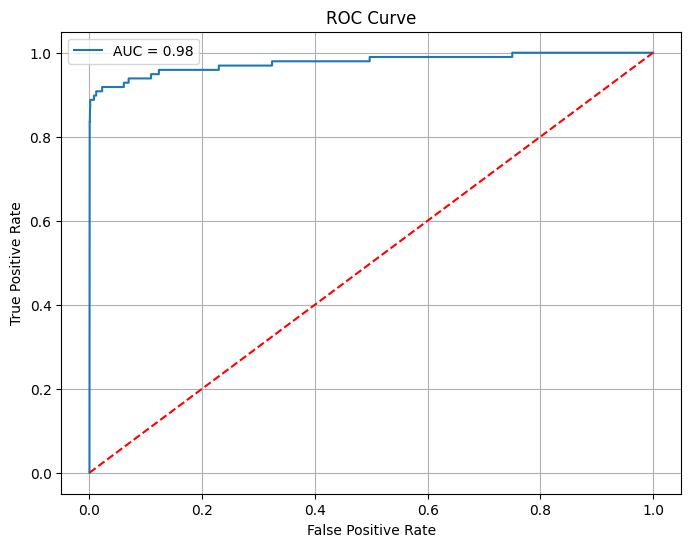

In [13]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


 Export fraud_model.pkl and scaler.pkl from Colab

In [16]:
import joblib

# Save the trained model and scaler
joblib.dump(model, "fraud_model.pkl")



['fraud_model.pkl']

In [17]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

Then run this to download the files to your system:

In [18]:
from google.colab import files

files.download("fraud_model.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:

files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Create and Save app.py from Google Colab

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
